In [1]:
import matplotlib.pyplot as plt
import numpy as np

from qctrlvisualizer import get_qctrl_style, plot_controls
from qctrl import Qctrl

qctrl = Qctrl()

### Pulso randômico

In [2]:
# Parâmetros: 
control_count = 5
shot_count = 32

### Pulso do closed-loop approach

In [3]:
# Define standard deviation of the errors in the experimental results.
sigma = 0.01

# Function to organize the experiment results into the proper input format.
def organize_results(omegas, infidelities):
    """
    This function accepts a list of parameters and a list of costs, and
    orgnizes them in a format that is accepted by the closed-loop optimizer.
    The uncertainties in the cost are assumed to be equal.
    """
    return [
        qctrl.types.closed_loop_optimization_step.CostFunctionResult(
            parameters=list(parameters), cost=cost, cost_uncertainty=sigma
        )
        for parameters, cost in zip(omegas, infidelities)
    ]

### Aqui escolhe o controle U_t = sigma_x ou h

In [4]:
# Define standard matrices.
sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
sigma_y = np.array([[0, -1j], [1j, 0]], dtype=complex)
sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)
h = np.array([[1/np.sqrt(2), 1/np.sqrt(2)], [1/np.sqrt(2), -1/np.sqrt(2)]], dtype=complex)

# Gate (controle) de interesse
U_t = h

# Define control parameters.
duration = 1e-6  # s

# Create a random unknown operator.
rng = np.random.default_rng(seed=10)
phi = rng.uniform(-np.pi, np.pi)
u = rng.uniform(-1, 1)
Q_unknown = (
    u * sigma_z + np.sqrt(1 - u ** 2) * (np.cos(phi) * sigma_x + np.sin(phi) * sigma_y)
) / 4


# Establish simulation model of quantum system for use in optimization loop
def run_experiments(omegas):
    """
    Simulates a series of experiments where controls `omegas` attempt to apply
    an X gate to a system. The result of each experiment is the infidelity plus
    a Gaussian error.

    In your actual implementation, this function would run the experiment with
    the parameters passed. Note that the simulation handles multiple test points,
    while your experimental implementation might need to queue the test point
    requests to obtain one at a time from the apparatus.
    """
    # Create the graph with the dynamics of the system.
    graph = qctrl.create_graph()
    signal = graph.pwc_signal(values=omegas, duration=duration)
    graph.infidelity_pwc(
        hamiltonian=0.5 * signal * (U_t + Q_unknown),
        target=graph.target(operator=U_t),
        name="infidelities",
    )

    # Run the simulation.
    result = qctrl.functions.calculate_graph(
        graph=graph, output_node_names=["infidelities"]
    )

    # Add error to the measurement.
    error_values = rng.normal(loc=0, scale=sigma, size=len(omegas))
    infidelities = result.output["infidelities"]["value"] + error_values

    # Return only infidelities between 0 and 1.
    return np.clip(infidelities, 0, 1)

In [5]:
# Define the number of test points obtained per run.
test_point_count = 20

# Define number of segments in the control.
segment_count = 10


def initialize_parameter_set():
    parameter_set = (
        (np.pi / duration)
        * (np.linspace(-1, 1, test_point_count)[:, None])
        * np.ones((test_point_count, segment_count))
    )

    return parameter_set


# Define parameters as a set of controls with piecewise constant segments.
parameter_set = initialize_parameter_set()

# Obtain a set of initial experimental results.
experiment_results = run_experiments(parameter_set)

Your task calculate_graph (action_id="708973") has completed.


In [6]:
# Define initialization object for the automated closed-loop optimization.
length_scale_bound = qctrl.types.closed_loop_optimization_step.BoxConstraint(
    lower_bound=1e-5, upper_bound=1e5
)
bound = qctrl.types.closed_loop_optimization_step.BoxConstraint(
    lower_bound=-5 * np.pi / duration, upper_bound=5 * np.pi / duration
)
initializer = qctrl.types.closed_loop_optimization_step.GaussianProcessInitializer(
    length_scale_bounds=[length_scale_bound] * segment_count,
    bounds=[bound] * segment_count,
    rng_seed=0,
)

# Define state object for the closed-loop optimization.
optimizer = qctrl.types.closed_loop_optimization_step.Optimizer(
    gaussian_process_initializer=initializer,
)

Best infidelity after 0 Boulder Opal optimization steps: 0.12916447480061508


Your task calculate_closed_loop_optimization_step (action_id="708975") has completed.


Your task calculate_graph (action_id="708977") has completed.
Best infidelity after 1 Boulder Opal optimization step: 0.03843473894771362


Your task calculate_closed_loop_optimization_step (action_id="708979") has completed.


Your task calculate_graph (action_id="708981") has completed.
Infidelity: 0.01314502572325854


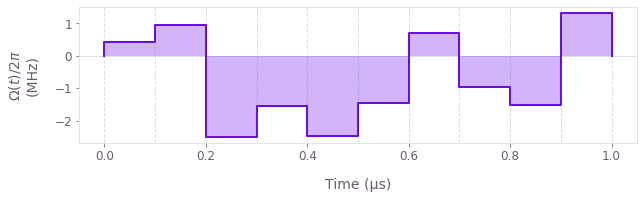

In [7]:
best_cost, best_controls = min(
    zip(experiment_results, parameter_set), key=lambda params: params[0]
)
optimization_count = 0

# Run the optimization loop until the cost (infidelity) is sufficiently small.
while best_cost > 3 * sigma:
    # Print the current best cost.
    optimization_steps = (
        "optimization step" if optimization_count == 1 else "optimization steps"
    )
    print(
        f"Best infidelity after {optimization_count} Boulder Opal {optimization_steps}: {best_cost}"
    )

    # Organize the experiment results into the proper input format.
    results = organize_results(parameter_set, experiment_results)

    # Call the automated closed-loop optimizer and obtain the next set of test points.
    optimization_result = qctrl.functions.calculate_closed_loop_optimization_step(
        optimizer=optimizer, results=results, test_point_count=test_point_count
    )
    optimization_count += 1

    # Organize the data returned by the automated closed-loop optimizer.
    parameter_set = np.array(
        [test_point.parameters for test_point in optimization_result.test_points]
    )
    optimizer = qctrl.types.closed_loop_optimization_step.Optimizer(
        state=optimization_result.state
    )

    # Obtain experiment results that the automated closed-loop optimizer requested.
    experiment_results = run_experiments(parameter_set)

    # Record the best results after this round of experiments.
    cost, controls = min(
        zip(experiment_results, parameter_set), key=lambda params: params[0]
    )
    if cost < best_cost:
        best_cost = cost
        best_controls = controls

# Print final best cost.
print(f"Infidelity: {best_cost}")

# Plot controls that correspond to the best cost.
plot_controls(
    figure=plt.figure(),
    controls={
        r"$\Omega(t)$": [
            {"duration": duration / len(best_controls), "value": value}
            for value in best_controls
        ]
    },
)

In [8]:
controls_h = []
for k in range(control_count):
    # Create a random string of complex numbers for each controls.
    #real_part = np.random.random(size=[segment_count])
    #imag_part = np.random.random(size=[segment_count])
    values = controls/10**(9)

    controls_h.append({"duration": duration, "values": values})

### Começa a usar o pulso para controle

In [9]:
# Obtain the results of the experiment.
experiment_results = qctrl.functions.calculate_hackathon_measurements(
    controls=controls_h, shot_count=shot_count
)

Your task calculate_hackathon_measurements (action_id="708984") has completed.


In [10]:
measurements = experiment_results.measurements
for k, measurement_counts in enumerate(measurements):
    print(f"control #{k}: {measurement_counts}")

control #0: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
control #1: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
control #2: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
control #3: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
control #4: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [11]:
for k, measurement_counts in enumerate(measurements):
    p0 = measurement_counts.count(0) / shot_count
    p1 = measurement_counts.count(1) / shot_count
    p2 = measurement_counts.count(2) / shot_count
    print(f"control #{k}: P(|0>) = {p0:.2f}, P(|1>) = {p1:.2f}, P(|2>) = {p2:.2f}")

control #0: P(|0>) = 1.00, P(|1>) = 0.00, P(|2>) = 0.00
control #1: P(|0>) = 1.00, P(|1>) = 0.00, P(|2>) = 0.00
control #2: P(|0>) = 1.00, P(|1>) = 0.00, P(|2>) = 0.00
control #3: P(|0>) = 0.94, P(|1>) = 0.06, P(|2>) = 0.00
control #4: P(|0>) = 0.97, P(|1>) = 0.03, P(|2>) = 0.00


In [12]:
repetitions = [1, 4, 16, 32, 64]

experiment_results = qctrl.functions.calculate_hackathon_measurements(
    controls=controls_h, shot_count=shot_count
)

for repetition_count, measurement_counts in zip(
    repetitions, experiment_results.measurements
):
    p0 = measurement_counts.count(0) / shot_count
    p1 = measurement_counts.count(1) / shot_count
    p2 = measurement_counts.count(2) / shot_count
    print(
        f"With {repetition_count:2d} repetitions: "
        f"P(|0>) = {p0:.2f}, P(|1>) = {p1:.2f}, P(|2>) = {p2:.2f}"
    )

Your task calculate_hackathon_measurements (action_id="708986") has completed.
With  1 repetitions: P(|0>) = 0.97, P(|1>) = 0.03, P(|2>) = 0.00
With  4 repetitions: P(|0>) = 0.94, P(|1>) = 0.06, P(|2>) = 0.00
With 16 repetitions: P(|0>) = 1.00, P(|1>) = 0.00, P(|2>) = 0.00
With 32 repetitions: P(|0>) = 1.00, P(|1>) = 0.00, P(|2>) = 0.00
With 64 repetitions: P(|0>) = 1.00, P(|1>) = 0.00, P(|2>) = 0.00


In [13]:
import jsonpickle.ext.numpy as jsonpickle_numpy
import jsonpickle

jsonpickle_numpy.register_handlers()

H_control = {"duration": duration, "values": best_controls/10**(9)}
h_gate_pulse = jsonpickle.encode(H_control)
with open("h_gate_pulse", "w") as file:
    file.write(h_gate_pulse)

In [14]:
#not_gate_pulse.json
# h_gate_pulse.json